# Video Game Sales Analysis

## 1. Import & Setup
Set up the environment and import necessary Python libraries like Pandas, NumPy, Matplotlib, Seaborn, and Plotly for analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Data Overview
Perform a first look at the dataset to understand its structure, size, and key columns.
- Used `data.info()` and `data.describe()` to check column types and summary statistics.
- Found 16 columns and over 16,000 records.
- Observed several missing values, especially in review-related fields (`Critic_Score`, `User_Score`, etc.).
- Confirmed no duplicate rows.
- Identified data type issues: `Year_of_Release` stored as float, `User_Score` stored as object.

In [2]:
# Read the CSV file
csv_path = "../data/Video_Games_Sales_as_at_22_Dec_2016.csv"  # adjust if name differs
df = pd.read_csv(csv_path)

# Convert to Parquet for faster reads later
parquet_path = "../data/video_games_sales.parquet"
df.to_parquet(parquet_path, index=False)

# Confirm conversion worked
print("Parquet file saved successfully!")

Parquet file saved successfully!


In [3]:
# Checking the head of the data NB: I prefer paraquet cause it's faster.
data = pd.read_parquet(parquet_path)
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Display shape (rows, columns)
print("Dataset shape:", data.shape)

# Quick summary of dataset info
print("\nQuick Facts about Dataset")
data.info()

# Check for missing values
print("\nMissing values per column:")
print(data.isna().sum())

# View column data types
print("\nData types:")
print(data.dtypes)

# Summary statistics for numeric columns
display(data.describe())

# Check unique counts for categorical columns (quick view)
print("\n")
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")

# Quick look at duplicate rows
print("\nDuplicate rows:", data.duplicated().sum())

Dataset shape: (16719, 16)

Quick Facts about Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: f

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000




Name: 11562 unique values
Platform: 31 unique values
Genre: 12 unique values
Publisher: 581 unique values
User_Score: 96 unique values
Developer: 1696 unique values
Rating: 8 unique values

Duplicate rows: 0


### 2.1 Data Overview Summary

- Rows and columns: 16,719 rows, 16 columns. Medium dataset.
- Core columns: Name, Platform, Year_of_Release, Genre, Publisher, regional sales, review scores, developer, rating.
- Missing data:
  - Small: Name (2), Genre (2), Year_of_Release (269), Publisher (54).
  - Large: Critic_Score (8,582), Critic_Count (8,582), User_Score (6,704), User_Count (9,129), Developer (6,623), Rating (6,769).
  - Conclusion: review-related columns are incomplete, so we should not drop all those rows.
- Data types:
  - Year_of_Release is float, should be integer.
  - User_Score is object, should be numeric, likely because of values like "tbd".
- No duplicate rows.
- Categorical richness: 31 platforms, 12 genres, 581 publishers, so we can group and aggregate later.
- Sales columns have no missing values, so analysis by sales is safe.

Next step (Cleaning & Fixes):
1. Fix dtypes (Year_of_Release → int, User_Score → numeric after handling "tbd").
2. Fill text columns with “Unknown” (Publisher, Developer, Rating).
3. Decide what to do with review columns (keep separate subset for score-based analysis).
4. Drop the 2–3 completely bad rows if needed.

## 3. Cleaning & Fixes
Steps taken to clean the dataset:
1. **Converted data types** – Fixed `Year_of_Release` (to Int64) and converted `User_Score` to numeric after replacing `'tbd'` with `NaN`.
2. **Handled missing values** – Filled missing categorical values (`Publisher`, `Developer`, `Rating`) with `'Unknown'`.
3. **Dropped incomplete rows** – Removed rows missing critical identifiers (`Name`, `Genre`, or `Year_of_Release`).
4. **Removed invalid records** – Excluded future release years (after 2016).
5. **Reset index** – To maintain sequential order after row drops.


After cleaning:
- All key descriptive columns are complete.
- Remaining missing values only affect optional review columns.
- Data types are now correct for all columns.


---

In [5]:
# 0. Normalize categorical columns for consistent grouping
for col in ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']:
    data[col] = data[col].astype(str).str.strip().str.upper()

# 1. fix user score
data['User_Score'] = data['User_Score'].replace('tbd', np.nan)
data['User_Score'] = pd.to_numeric(data['User_Score'], errors='coerce')

# 2. fill text columns
for col in ['Publisher', 'Developer', 'Rating']:
    data[col] = data[col].fillna('Unknown')

# 3. drop rows that miss key info
data = data.dropna(subset=['Name', 'Genre', 'Year_of_Release'])

# 4. make year integer
data['Year_of_Release'] = data['Year_of_Release'].astype('Int64')

# 5. remove future years
data = data[data['Year_of_Release'] <= 2016]

# 6. reset index
data = data.reset_index(drop=True)

# 7. Checking the Quick Fact about Data again after cleaning
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16444 non-null  object 
 1   Platform         16444 non-null  object 
 2   Year_of_Release  16444 non-null  Int64  
 3   Genre            16444 non-null  object 
 4   Publisher        16444 non-null  object 
 5   NA_Sales         16444 non-null  float64
 6   EU_Sales         16444 non-null  float64
 7   JP_Sales         16444 non-null  float64
 8   Other_Sales      16444 non-null  float64
 9   Global_Sales     16444 non-null  float64
 10  Critic_Score     7983 non-null   float64
 11  Critic_Count     7983 non-null   float64
 12  User_Score       7463 non-null   float64
 13  User_Count       7463 non-null   float64
 14  Developer        16444 non-null  object 
 15  Rating           16444 non-null  object 
dtypes: Int64(1), float64(9), object(6)
memory usage: 2.0+ MB


## 4. Feature Engineering

In this step, we create new derived features that add analytical value:

- **game_age** – The number of years since the game’s release (using 2016 as the reference year).  
- **has_critic** – Binary flag (1/0) showing whether a game has critic review data.  
- **has_user** – Binary flag (1/0) showing whether a game has user review data.  
- **regional_sum** – The total of regional sales (`NA`, `EU`, `JP`, and `Other`) to compare with `Global_Sales` for data consistency checks.

These engineered columns help us:
- Analyze trends in sales relative to game age.
- Filter datasets based on available review information.
- Verify whether global sales match the sum of regional sales.



In [6]:
# 1. game_age
CURRENT_YEAR = 2016  # dataset is up to 2016
data['game_age'] = CURRENT_YEAR - data['Year_of_Release']

# 2. review availability flags
data['has_critic'] = data['Critic_Score'].notna().astype(int)
data['has_user'] = data['User_Score'].notna().astype(int)

# 3. regional vs global check
data['regional_sum'] = (
    data['NA_Sales'] +
    data['EU_Sales'] +
    data['JP_Sales'] +
    data['Other_Sales']
)

# sometimes global is slightly different due to rounding, so we keep both
data[['Year_of_Release', 'game_age', 'has_critic', 'has_user']].head()

,Year_of_Release,game_age,has_critic,has_user
0,2006,10,1,1
1,1985,31,0,0
2,2008,8,1,1
3,2009,7,1,1
4,1996,20,0,0


## 5. Univariate Analysis

This section examines each major variable separately to understand the dataset’s overall structure and distribution patterns.

Key objectives:
- Identify the most common platforms, genres, and publishers.
- Visualize the distribution of global sales.
- Spot potential skews or outliers in numeric variables.

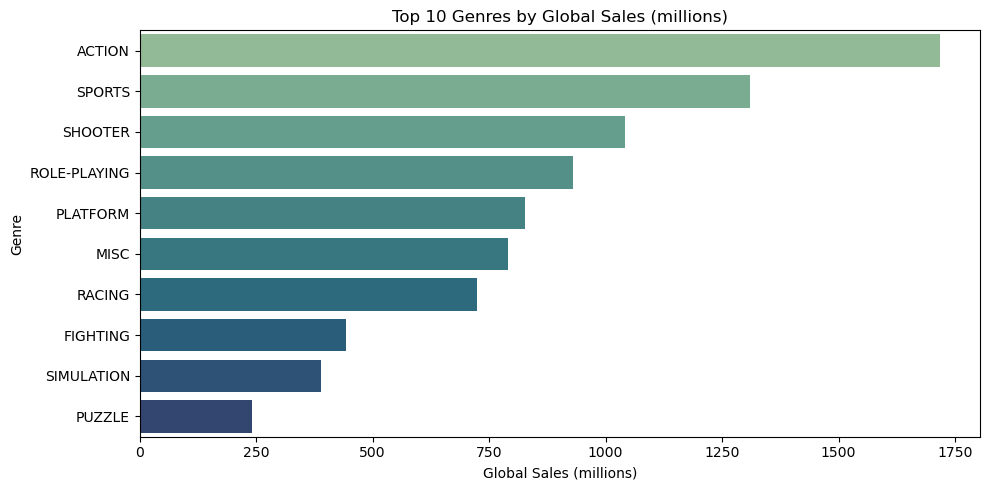

In [7]:
# --- 5.1 Top 10 Genres by Global Sales ---
genre_sales = (
    data.groupby("Genre")["Global_Sales"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(x=genre_sales.values, y=genre_sales.index, hue=genre_sales.index, palette="crest")
plt.title("Top 10 Genres by Global Sales (millions)")
plt.xlabel("Global Sales (millions)")
plt.ylabel("Genre")
plt.tight_layout()

# Save figure to the figures folder
plt.savefig("../figures/top10_genres_sales.png", dpi=300)
plt.show()

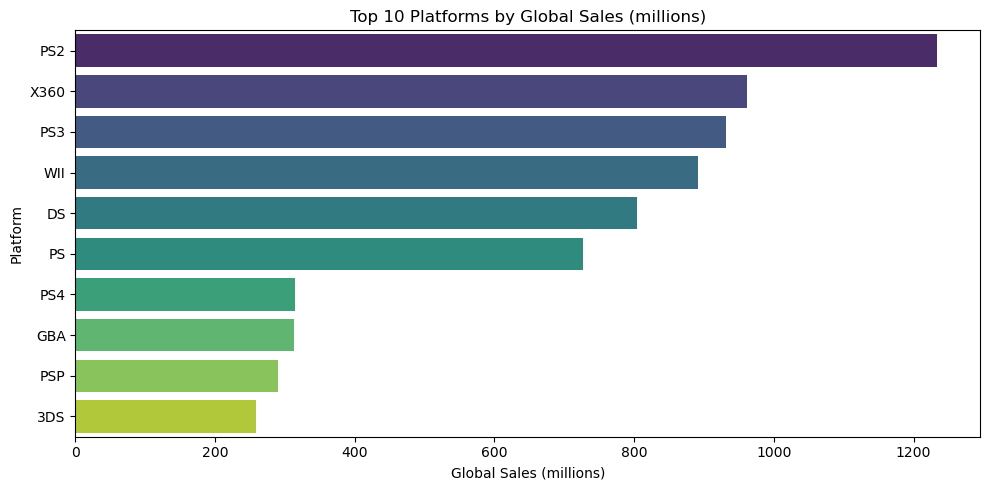

In [8]:
# --- 5.2 Top 10 Platforms by Global Sales ---

# 1. group by platform and sum sales
platform_sales = (
    data.groupby("Platform")["Global_Sales"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# 2. plot
plt.figure(figsize=(10, 5))
sns.barplot(
    x=platform_sales.values,
    y=platform_sales.index,
    hue=platform_sales.index,
    palette="viridis",
    legend=False
)
plt.title("Top 10 Platforms by Global Sales (millions)")
plt.xlabel("Global Sales (millions)")
plt.ylabel("Platform")
plt.tight_layout()

# 3. save
plt.savefig("../figures/top10_platforms_sales.png", dpi=300)
plt.show()

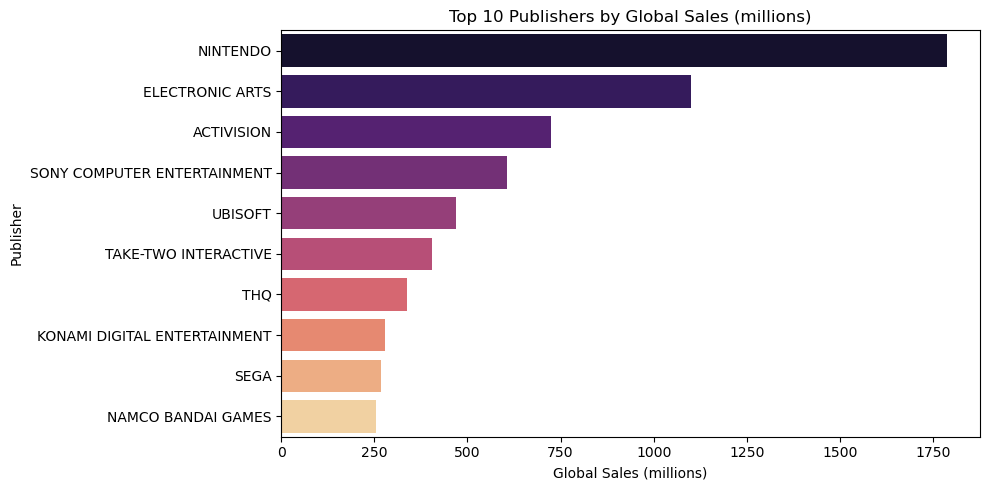

In [11]:
# --- 5.3 Top 10 Publishers by Global Sales ---

# 1. Aggregate total global sales by publisher
publisher_sales = (
    data.groupby("Publisher")["Global_Sales"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# 2. Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    x=publisher_sales.values,
    y=publisher_sales.index,
    hue=publisher_sales.index,
    palette="magma",
    legend=False
)
plt.title("Top 10 Publishers by Global Sales (millions)")
plt.xlabel("Global Sales (millions)")
plt.ylabel("Publisher")
plt.tight_layout()

# 3. Save figure
plt.savefig("../figures/top10_publishers_sales.png", dpi=300)
plt.show()

## 6. Bivariate Analysis

## 7. Summary & Conclusions